In [1]:
%cd HW1
%matplotlib inline


/home/zhaoyilin/AML/HW1


In [4]:
import numpy as np
import tqdm
import copy
from matplotlib import pyplot as plt


from experts_advice import ExpertsAdvice
from config import cloud_config, spambase_config
from experts import TheDataset

# Function

In [20]:

def jupyter_main(config):
    experts_advice=ExpertsAdvice(config)
    dataset = TheDataset(config.data_path, is_train=True, num_features=config.experts.expert.in_features)
    distributions = []
    experts_losses = []

    for i, sample in tqdm.tqdm(enumerate(dataset)):
        x, y = sample
        experts_loss = experts_advice.train(x, y)
        distributions.append(copy.deepcopy(experts_advice.distribution))
        experts_losses.append(experts_loss)

    distributions = np.array(distributions)
    smoothing = 200
    for i_expert in range(cloud_config.num_experts):
        dist_over_iter = distributions[:, i_expert]
        smoothed_list = []
        for i in range(dist_over_iter.shape[0]):
            index_min, index_max = max(0, i-smoothing), min(dist_over_iter.shape[0], i+smoothing)
            smoothed = dist_over_iter[index_min: index_max]
            smoothed_list.append(np.mean(smoothed))
        plt.plot(smoothed_list, label=f'expert {i_expert} weights')

    plt.legend()
    plt.title('expert weights over iterations')
    plt.show()


    eval_dataset = TheDataset(config.data_path, is_train=False, num_features=config.experts.expert.in_features)
    total, cost = len(eval_dataset), 0
    for sample in tqdm.tqdm(eval_dataset):
        x, y = sample
        pred_y = experts_advice.predict(x)
        if config.task_type == 'classification': 
            pred_y = int(pred_y > 0.5)
            if y != pred_y:
                cost += 1
        elif config.task_type == 'regression':
            cost += (pred_y - y) ** 2
        else:
            raise NotImplementedError()
        
    print(f'after iterating same training data--experts advice error on same eval data: {cost/total:.4f}')


# Cloud: Regression

[Expert(
  (input_layer): Sequential(
    (0): Linear(in_features=9, out_features=1, bias=True)
  )
  (output_layer): Identity()
  (layers): ModuleList()
), Expert(
  (input_layer): Sequential(
    (0): Linear(in_features=9, out_features=8, bias=True)
    (1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (output_layer): Linear(in_features=8, out_features=1, bias=True)
  (layers): ModuleList()
), Expert(
  (input_layer): Sequential(
    (0): Linear(in_features=9, out_features=8, bias=True)
    (1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (output_layer): Linear(in_features=8, out_features=1, bias=True)
  (layers): ModuleList(
    (0): Linear(in_features=8, out_features=8, bias=True)
    (1): ReLU()
  )
), Expert(
  (input_layer): Sequential(
    (0): Linear(in_features=9, out_features=8, bias=True)
    (1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running

1638it [00:04, 362.42it/s]


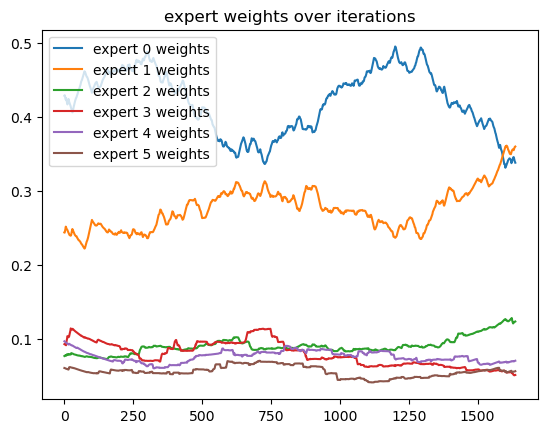

100%|██████████| 410/410 [00:01<00:00, 402.28it/s]

after iterating same training data--experts advice error on same eval data: 51.6868


In [21]:
jupyter_main(cloud_config)


# Spambase: Classification

[Expert(
  (input_layer): Sequential(
    (0): Linear(in_features=57, out_features=1, bias=True)
  )
  (output_layer): Identity()
  (layers): ModuleList()
), Expert(
  (input_layer): Sequential(
    (0): Linear(in_features=57, out_features=16, bias=True)
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (output_layer): Linear(in_features=16, out_features=1, bias=True)
  (layers): ModuleList()
), Expert(
  (input_layer): Sequential(
    (0): Linear(in_features=57, out_features=16, bias=True)
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (output_layer): Linear(in_features=16, out_features=1, bias=True)
  (layers): ModuleList(
    (0): Linear(in_features=16, out_features=16, bias=True)
    (1): ReLU()
  )
), Expert(
  (input_layer): Sequential(
    (0): Linear(in_features=57, out_features=16, bias=True)
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True,

0it [00:00, ?it/s]

3681it [00:09, 393.17it/s]


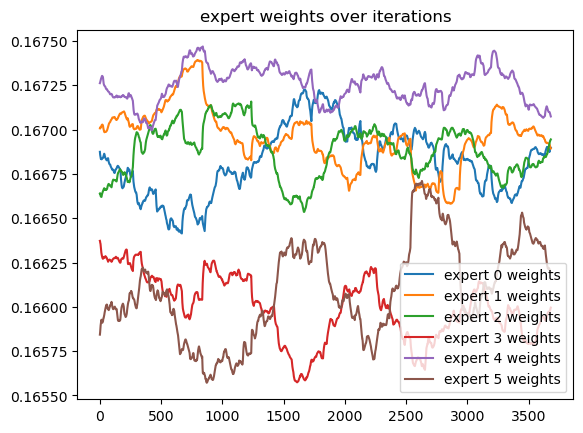

100%|██████████| 920/920 [00:02<00:00, 364.09it/s]

after iterating same training data--experts advice error on same eval data: 0.1000


In [22]:
jupyter_main(spambase_config)
